# Ciscenje podataka + prediktivno

In [3]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

import matplotlib.pyplot  as plt

from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix

from sklearn.metrics import roc_curve, roc_auc_score

In [4]:
df = pd.read_csv('Drugi domaći zadatak/bank-additional.csv', sep = ';')
data = df
pd.set_option('display.max_columns', 100)          #Da se prikazu sve kolone
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487.0,2.0,999,0.0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,346.0,4.0,999,0.0,nonexistent,1.1,93.994,-36.4,4.855,5191,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227.0,1.0,999,0.0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,17.0,3.0,999,0.0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58.0,1.0,999,0.0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [5]:
#Izbacimo sve redove sa null vrednostima. Ima ih svega 21 i sporadicno su rasporedjene, tako da ovo nece znacajno uticati na predikcije


#df.isnull().sum() #Provera null vrednosti

df = df.dropna()  #Izbacivanje null vrednosti

df.isnull().sum()   #Provera

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [6]:
#Provera prisustva 'unknown' vrednosti. 

df.isin(['unknown']).sum()

#Bez obzira da li stavimo & ili | isti je rezultat stoga sledi da gde se unknown pojavi u loan pojavi se iskljucivo i u housing

#df[(df['loan']=='unknown') & (df['housing'] == 'unknown')].count() 




age                 0
job                38
marital            11
education         165
default           794
housing           103
loan              103
contact             0
month               0
day_of_week         0
duration            0
campaign            0
pdays               0
previous            0
poutcome            0
emp.var.rate        0
cons.price.idx      0
cons.conf.idx       0
euribor3m           0
nr.employed         0
y                   0
dtype: int64

In [7]:
#Obzirom da ima samo 103 slucaja kada nam se to pojavljuje mozemo izbaciti te redove bez narocitih posledica po predikcije

df = df[df.housing != 'unknown']

#Izbacujemo i unknown redove u marital jer ih ima samo 11
df = df[df.marital != 'unknown']

df.isin(['unknown']).sum()

age                 0
job                38
marital             0
education         164
default           770
housing             0
loan                0
contact             0
month               0
day_of_week         0
duration            0
campaign            0
pdays               0
previous            0
poutcome            0
emp.var.rate        0
cons.price.idx      0
cons.conf.idx       0
euribor3m           0
nr.employed         0
y                   0
dtype: int64

U koloni default i education 'unknown' je znacajna vrednost (pogotovo u odnosu na broj instanci atributa) tako da bismo to mogli pretvoriti u num vrednost neku

Job planiramo da sibnemo u get_dummies pa ako ih je mnogo malo u odnosu na druge atribute onda cemo videti da li da izbacujemo, sada necemo

## Prebacivanje kategorickih u num vrednosti

In [8]:
#Education pretvaramo u num:

df['education'] = df['education'].map({"unknown":0,"illiterate" : 1, "basic.4y" : 2,"basic.6y" :3,"basic.9y" :4,"high.school" : 5,"professional.course":6,"university.degree":7})

In [9]:
#Month pretvaramo u num:
import calendar
month_int = {month.lower() : idx for idx, month in enumerate(calendar.month_abbr) if month}

df['month'].replace(month_int, inplace = True)

In [10]:
#Day pretvaramo u num:

day_num = {day.lower() : idx for idx, day in enumerate(calendar.day_abbr) if day}
df['day_of_week'].replace(day_num, inplace = True)

In [11]:
# Poutcome pretvaramo u num - JAKO BITNO

poutcome_num = {'nonexistent': 0,'failure' : 1, 'success' : 2}
df['poutcome'].replace(poutcome_num,inplace = True)

In [12]:
# Contact pretvaramo u num

contact_num = {'cellular':0,'telephone':1}
df['contact'].replace(contact_num,inplace = True)

In [13]:
# default pretvaramo u num (no = 0, unknown = 1)

default_num = {'no':0,'unknown':1,'yes':1}
df['default'].replace(default_num,inplace = True)

In [14]:
#  loan, y, housing u num yes/no vrednosti

yes_no_num = {'yes':1,'no' : 0}
for col in ['housing','y','loan'] :
    df[col].replace(yes_no_num, inplace = True)

In [15]:
#Iz nekog razloga je nr.employed pokazivalo kao object pa smo ga prebacili u float64

df['nr.employed'] = df['nr.employed'].astype('float64')

df['nr.employed'].value_counts()

5228.1    1567
5099.1     801
5191.0     729
5195.8     383
5076.2     159
5017.5     102
4991.6      85
4963.6      80
5008.7      56
5023.5      21
5176.3       1
Name: nr.employed, dtype: int64

In [16]:
df.head()

#Sad jos ostaje da job i martial prebacimo tako sto cemo da iskoristimo get_dummies i od tih vrednosti napravimo atribute sa binarnim vrednostima

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,4,0,1,0,0,5,4,487.0,2.0,999,0.0,0,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,services,single,5,0,0,0,1,5,4,346.0,4.0,999,0.0,0,1.1,93.994,-36.4,4.855,5191.0,0
2,25,services,married,5,0,1,0,1,6,2,227.0,1.0,999,0.0,0,1.4,94.465,-41.8,4.962,5228.1,0
4,47,admin.,married,7,0,1,0,0,11,0,58.0,1.0,999,0.0,0,-0.1,93.200,-42.0,4.191,5195.8,0
5,32,services,single,7,0,0,0,0,9,3,128.0,3.0,999,2.0,1,-1.1,94.199,-37.5,0.884,4963.6,0


In [17]:
df = pd.get_dummies(df, columns = ['job','marital'], drop_first = True)
df.shape

(3984, 32)

In [18]:
[df['default'].value_counts(),df['y'].value_counts()]

[0    3213
 1     771
 Name: default, dtype: int64,
 0    3544
 1     440
 Name: y, dtype: int64]

## Potencijalno izbacivanje i uredjivanje kolona koje smo uvideli da imaju neke outliere

In [19]:
df[['pdays', 'campaign', 'previous']].describe()

,pdays,campaign,previous
count,3984.000000,3984.000000,3984.000000
mean,960.111446,2.535894,0.188755
std,192.665310,2.577295,0.537813
min,0.000000,1.000000,0.000000
25%,999.000000,1.000000,0.000000
50%,999.000000,2.000000,0.000000
75%,999.000000,3.000000,0.000000
max,999.000000,35.000000,6.000000


In [20]:
#Sa slika vidimo da je pdays 96% kolone jednak 999 sto znaci da klijenti nisu ni kontaktirani, ovo je outlier i trebalo bi da se ta kolona dropuje

#len(df[df['pdays'] ==999])/len(df)*100

#
len(df[df['pdays'] ==0])


#df['pdays'].value_counts()

2

In [21]:
len(df[df['previous'] <=2.5])/len(df)*100

98.99598393574297

In [22]:
len(df[df['campaign'] <=14])#/len(df)*100

#Vidimo da je sve preko 14 za capaign sum (ima ih 35), pretvoricemo ih u mean

3949

In [23]:
df['campaign'].mean()

2.5358935742971886

In [24]:
#Dropujemo pdays

df = df.drop(columns = ['pdays'])

In [25]:
#Popunimo outliere sa mean vrednostima u kolonama campaign i previous

def dobra_vrednost(row, column_name, prag, df):
    ''' Returns mean value if value in column_name is above threshold'''
    if row[column_name] <= prag:
        return row[column_name]
    else:
        mean = df[df[column_name] <= prag][column_name].mean()
        return mean
    
df['campaign'] = df.apply(lambda row: dobra_vrednost(row, 'campaign', 2.5, df),axis=1)
df['previous'] = df.apply(lambda row: dobra_vrednost(row, 'previous', 5, df),axis=1)

In [26]:
df_clean = df
df_clean.head()

,age,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single
0,30,4,0,1,0,0,5,4,487.0,2.000000,0.0,0,-1.8,92.893,-46.2,1.313,5099.1,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1,39,5,0,0,0,1,5,4,346.0,1.372333,0.0,0,1.1,93.994,-36.4,4.855,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,25,5,0,1,0,1,6,2,227.0,1.000000,0.0,0,1.4,94.465,-41.8,4.962,5228.1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,47,7,0,1,0,0,11,0,58.0,1.000000,0.0,0,-0.1,93.200,-42.0,4.191,5195.8,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,32,7,0,0,0,0,9,3,128.0,1.372333,2.0,1,-1.1,94.199,-37.5,0.884,4963.6,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [ ]:
df_clean.to_csv(r'C:\Users\Boka\Desktop\Masinsko ucenje\Mašinsko učenje dan 07\data\df_clean.csv', index = False)

# PREDIKTIVNO!

In [27]:
X = df_clean.drop('y', axis=1)
y = df_clean['y']

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)

In [29]:
# KNN
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X, y)
accuracy_score(y, model.predict(X))

0.9257028112449799

In [30]:
# Logristic Regression

from sklearn.linear_model import LogisticRegression
model_LR = LogisticRegression()
model_LR.fit(X, y)
accuracy_score(y, model_LR.predict(X))

0.9103915662650602

In [31]:
# DecisionTree

from sklearn.tree import DecisionTreeClassifier
model_DT = DecisionTreeClassifier(max_depth=5)
model_DT.fit(X, y)
accuracy_score(y, model_DT.predict(X))

0.9299698795180723

## Radimo za KNN

#### Pravimo model, fitujemo i predvidjamo. Zatim proveravamo sve relevantne metrike :

In [32]:
def print_performance(y, y_hat):
    print(f'Accuracy: {accuracy_score(y, y_hat)}')
    print(f'Precision: {precision_score(y, y_hat)}')
    print(f'Recall: {recall_score(y, y_hat)}')
    print(f'F1: {f1_score(y, y_hat)}')

In [33]:
model = KNeighborsClassifier( n_neighbors=5)
model.fit(X_train, y_train)
predictions= model.predict(X_train)


probas = model.predict_proba(X_train)
pred_proba = probas[:, 1]
roc = round(roc_auc_score(y_train, pred_proba),4)

cfm = confusion_matrix(y_true=y_train, y_pred=predictions)

print(cfm)
print_performance(y_train, predictions)
print('AUC', roc)

[[2414   69]
 [ 135  170]]
Accuracy: 0.926829268292683
Precision: 0.7112970711297071
Recall: 0.5573770491803278
F1: 0.625
AUC 0.9624


#### Cross validacija za  train podatke

In [34]:
from sklearn.model_selection import cross_val_score
results = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
# Kros validiran accuracy, sa devijacijom
print('Cross validated accuracy je: ',results.mean())

print('Cross validated standarardna devijacija za accuracy je: ',results.std())

Cross validated accuracy je:  0.895250251411774
Cross validated standarardna devijacija za accuracy je:  0.020607312935975043


#### ROC :

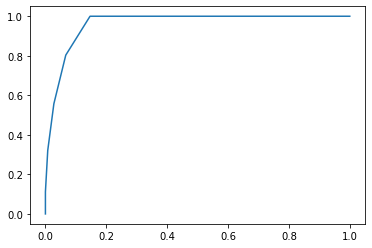

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train, pred_proba)
plt.plot(fpr, tpr)

#### Radimo isto za test podatke

In [36]:
#model = KNeighborsClassifier( n_neighbors=5)
model = KNeighborsClassifier( n_neighbors=5)
model.fit(X_train, y_train)
predictions= model.predict(X_test)


probas = model.predict_proba(X_test)
pred_proba = probas[:, 1]
roc = round(roc_auc_score(y_test, pred_proba),4)

cfm = confusion_matrix(y_true=y_test, y_pred=predictions)

print(cfm)
print_performance(y_test, predictions)
print('AUC', roc)

[[1000   61]
 [  77   58]]
Accuracy: 0.8846153846153846
Precision: 0.48739495798319327
Recall: 0.42962962962962964
F1: 0.45669291338582674
AUC 0.8567


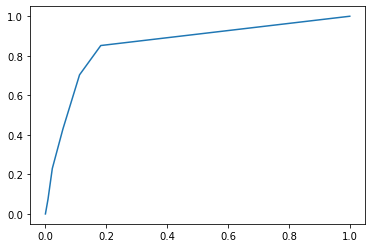

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
plt.plot(fpr, tpr)

### Granice

In [ ]:
predictions = model.predict_proba(X_train)[:, 1] >= 0.9
confusion_matrix(y_train, predictions)

### Uporedjivanje za razlicite parametre

#### 1) Za KNeighborsClassifier( n_neighbors=5) 
       UCENO NA TRAIN, PROVERA NA TEST: 
        [[2415   68]
         [ 137  168]]
            Accuracy: 0.9264705882352942
            Precision: 0.711864406779661
            Recall: 0.5508196721311476
            F1: 0.6210720887245841
            AUC 0.9633
            Cross validated accuracy je:  0.895250251411774
            Cross validated standarardna devijacija za accuracy je:  0.020607312935975043
            
            
       Ucenje na train, provera na test:
            [[1000   61]
             [  77   58]]
            Accuracy: 0.8846153846153846
            Precision: 0.48739495798319327
            Recall: 0.42962962962962964
            F1: 0.45669291338582674
            AUC 0.8567           
            
            
#### 2) Za KNeighborsClassifier( n_neighbors=2) 
           
           UCENO NA TRAIN, PROVERA NA TEST:
            [[2483    0]
             [ 171  134]]
            Accuracy: 0.9386657101865137
            Precision: 1.0
            Recall: 0.43934426229508194
            F1: 0.6104783599088839
            AUC 0.9826
   
            Cross validated accuracy je:  0.8966865217503417
            Cross validated standarardna devijacija za accuracy je:  0.018356628172358894
            
            Ucenje na train, provera na test:
            
            [[1000   61]
             [  77   58]]
            Accuracy: 0.8846153846153846
            Precision: 0.48739495798319327
            Recall: 0.42962962962962964
            F1: 0.45669291338582674
            AUC 0.8567
            
#### 3) Za KNeighborsClassifier( n_neighbors=50) 
            
           UCENO NA TRAIN, PROVERA NA TEST: 
                [[2421   62]
                 [ 169  136]]
                Accuracy: 0.917144906743185
                Precision: 0.6868686868686869
                Recall: 0.4459016393442623
                F1: 0.540755467196819
                AUC 0.9385
               Cross validated accuracy je:  0.9121154689151905
               Cross validated standarardna devijacija za accuracy je:  0.016108892158719003
               
            Ucenje na train, provera na test:    
                [[1000   61]
                 [  77   58]]
                Accuracy: 0.8846153846153846
                Precision: 0.48739495798319327
                Recall: 0.42962962962962964
                F1: 0.45669291338582674
                AUC 0.8567

## Radimo za Decision Tree

#### Pravimo model, fitujemo i predvidjamo. Zatim proveravamo sve relevantne metrike :

In [38]:
model = DecisionTreeClassifier(max_depth = 5)
model.fit(X_train, y_train)
predictions= model.predict(X_train)


probas = model.predict_proba(X_train)
pred_proba = probas[:, 1]
roc = round(roc_auc_score(y_train, pred_proba),4)

cfm = confusion_matrix(y_true=y_train, y_pred=predictions)

print(cfm)
print_performance(y_train, predictions)
print('AUC', roc)

[[2415   68]
 [ 110  195]]
Accuracy: 0.936154949784792
Precision: 0.7414448669201521
Recall: 0.639344262295082
F1: 0.6866197183098592
AUC 0.9368


#### Cross validacija za  train podatke

In [39]:
from sklearn.model_selection import cross_val_score
results = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
# Kros validiran accuracy, sa devijacijom
print('Cross validated accuracy je: ',results.mean())

print('Cross validated standarardna devijacija za accuracy je: ',results.std())

Cross validated accuracy je:  0.9121154689151905
Cross validated standarardna devijacija za accuracy je:  0.01602085573955331


#### ROC :

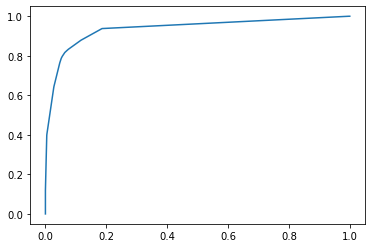

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train, pred_proba)
plt.plot(fpr, tpr)

#### Radimo isto za test podatke

In [41]:
model = DecisionTreeClassifier(max_depth = 5)
model.fit(X_train, y_train)
predictions= model.predict(X_test)


probas = model.predict_proba(X_test)
pred_proba = probas[:, 1]
roc = round(roc_auc_score(y_test, pred_proba),4)

cfm = confusion_matrix(y_true=y_test, y_pred=predictions)

print(cfm)
print_performance(y_test, predictions)
print('AUC', roc)

[[1013   48]
 [  72   63]]
Accuracy: 0.8996655518394648
Precision: 0.5675675675675675
Recall: 0.4666666666666667
F1: 0.5121951219512195
AUC 0.8958


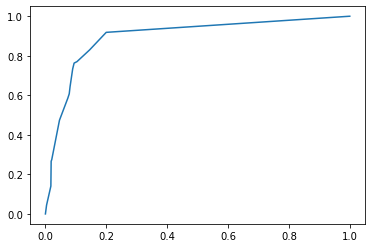

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
plt.plot(fpr, tpr)

### Uporedjivanje za razlicite parametre

#### 1) Za DecisionTreeClassifier(max_depth = 5)

        UCENO NA TRAIN, PROVERA NA TEST: 
            [[2415   68]
             [ 110  195]]
            Accuracy: 0.936154949784792
            Precision: 0.7414448669201521
            Recall: 0.639344262295082
            F1: 0.6866197183098592
            AUC 0.9368
            Cross validated accuracy je:  0.9117583352672701
            Cross validated standarardna devijacija za accuracy je:  0.016088247750248755
      
      UCENO NA TRAIN, PROVERA NA TEST:
            [[1013   48]
             [  72   63]]
            Accuracy: 0.8996655518394648
            Precision: 0.5675675675675675
            Recall: 0.4666666666666667
            F1: 0.5121951219512195
            AUC 0.89587  

#### 2) Za DecisionTreeClassifier(max_depth = 2)


        UCENO NA TRAIN, PROVERA NA TEST: 
            [[2459   24]
             [ 242   63]]
            Accuracy: 0.9045911047345767
            Precision: 0.7241379310344828
            Recall: 0.20655737704918034
            F1: 0.32142857142857145
            AUC 0.8622
            Cross validated accuracy je:  0.9063768340166577
            Cross validated standarardna devijacija za accuracy je:  0.012423473558549395
      
      UCENO NA TRAIN, PROVERA NA TEST:
            [[1013   48]
             [  72   63]]
            Accuracy: 0.8996655518394648
            Precision: 0.5675675675675675
            Recall: 0.4666666666666667
            F1: 0.5121951219512195
            AUC 0.8958

            
#### 2) Za DecisionTreeClassifier(max_depth = 15)      

        UCENO NA TRAIN, PROVERA NA TEST: 
            [[2480    3]
             [   3  302]]
            Accuracy: 0.9978479196556671
            Precision: 0.9901639344262295
            Recall: 0.9901639344262295
            F1: 0.9901639344262295
            AUC 1.0
            Cross validated accuracy je:  0.8898816430726386
            Cross validated standarardna devijacija za accuracy je:  0.014009588537899867
      
      UCENO NA TRAIN, PROVERA NA TEST:
            [[1013   48]
             [  72   63]]
            Accuracy: 0.8996655518394648
            Precision: 0.5675675675675675
            Recall: 0.4666666666666667
            F1: 0.5121951219512195
            AUC 0.8958

## Radimo za Linearnu regresiju

#### Pravimo model, fitujemo i predvidjamo. Zatim proveravamo sve relevantne metrike :

In [43]:
model = LogisticRegression()
model.fit(X_train, y_train)
predictions= model.predict(X_train)


probas = model.predict_proba(X_train)
pred_proba = probas[:, 1]
roc = round(roc_auc_score(y_train, pred_proba),4)

cfm = confusion_matrix(y_true=y_train, y_pred=predictions)

print(cfm)
print_performance(y_train, predictions)
print('AUC', roc)

[[2430   53]
 [ 183  122]]
Accuracy: 0.9153515064562411
Precision: 0.6971428571428572
Recall: 0.4
F1: 0.5083333333333333
AUC 0.9274


#### Cross validacija za  train podatke

In [44]:
from sklearn.model_selection import cross_val_score
results = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
# Kros validiran accuracy, sa devijacijom
print('Cross validated accuracy je: ',results.mean())

print('Cross validated standarardna devijacija za accuracy je: ',results.std())

Cross validated accuracy je:  0.913544003506872
Cross validated standarardna devijacija za accuracy je:  0.018945176008533796


#### ROC :

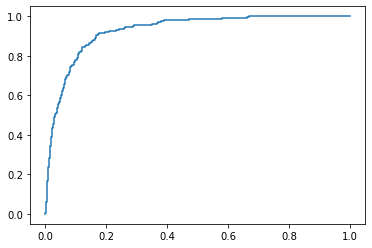

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train, pred_proba)
plt.plot(fpr, tpr)

#### Radimo isto za test podatke

In [46]:
model = LogisticRegression()
model.fit(X_train, y_train)
predictions= model.predict(X_test)


probas = model.predict_proba(X_test)
pred_proba = probas[:, 1]
roc = round(roc_auc_score(y_test, pred_proba),4)

cfm = confusion_matrix(y_true=y_test, y_pred=predictions)

print(cfm)
print_performance(y_test, predictions)
print('AUC', roc)

[[1026   35]
 [  83   52]]
Accuracy: 0.9013377926421404
Precision: 0.5977011494252874
Recall: 0.3851851851851852
F1: 0.46846846846846846
AUC 0.9116


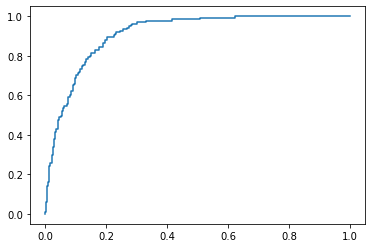

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
plt.plot(fpr, tpr)